In [1]:
import torch
import sys
from torchviz import make_dot
import numpy as np

In [2]:
sys.path.append('../src')
sys.path.append('../src/ml_variants/unet/pipelines/training/')

In [3]:
from ml_variants.unet.pipelines.training.steps.trainers import Sat2Rad

In [4]:
model = Sat2Rad()

cpu


In [5]:
input = torch.ones((2, 16, 16))

In [6]:
input

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1.,

In [7]:
# yhat = model(np.zeros((1, 1)))

In [8]:
import os
from util.parse_time import *
import matplotlib.pyplot as plt

In [9]:
model = Sat2Rad.load_from_checkpoint("../src/ml_variants/unet/pipelines/training/lightning_logs/version_23/checkpoints/epoch=3-step=1320.ckpt")

cpu


In [10]:
def loadFile(file: str):
    arr = np.load(file)
    return addTimeDim(arr, file)


def addTimeDim(array: np.ndarray, time: str):
    now = parseTime(time).hour / 24
    times = np.array([now]).repeat(256 * 256).reshape((1, 256, 256))
    return np.concatenate((array, times), axis=0)

In [11]:
start = 308

In [62]:
originals = order_based_on_file_timestamp(os.listdir('../data/preprocessed/satellite/'))[start:start+8]

In [63]:
radars = order_based_on_file_timestamp(os.listdir('../data/preprocessed/radar'))

In [64]:
timesRadar = [parseTime(s) for s in radars]

In [65]:
originals[0]

'MSG4-SEVI-MSG15-0100-NA-20230315001244.266000000Z-NA.npy'

In [66]:
start, end = get_next_sequence(8, originals[-1], radars)

In [67]:
radarimg = [np.load(f"../data/preprocessed/radar-binned/{x}") for x in radars[start:end]]

In [68]:
times = [parseTime(s) for s in originals]
timesRadar = [parseTime(s) for s in radars[start:end]]

In [69]:
x = [loadFile(f"../data/preprocessed/satellite/{x}") for x in originals]

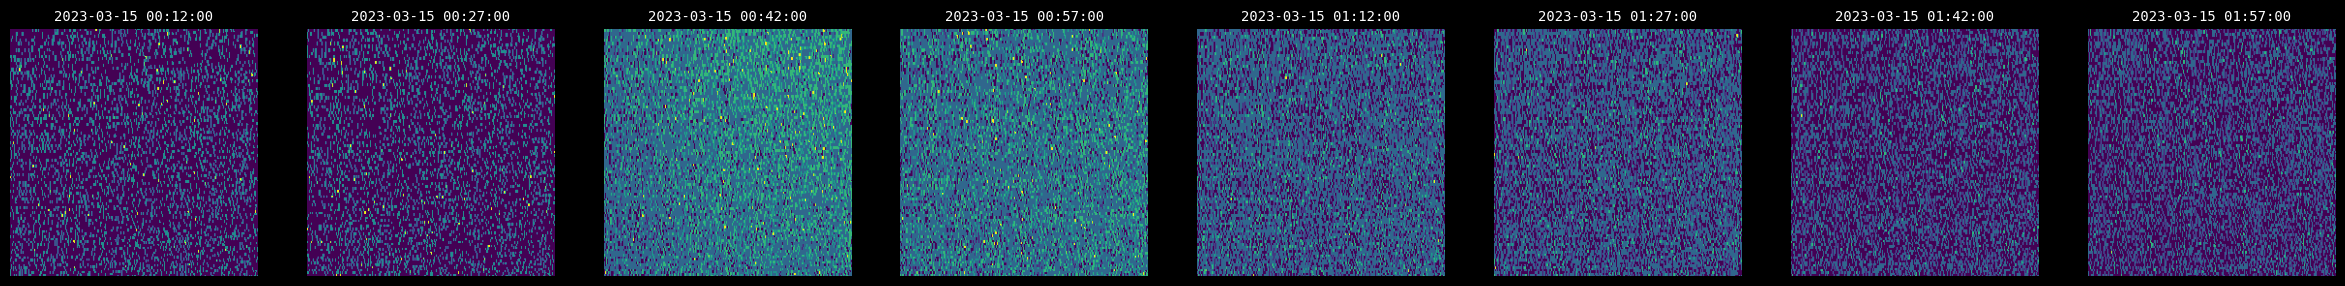

In [70]:
f, a = plt.subplots(1, 8, figsize=(30, 10))
for i, dd in enumerate(x):
    a[i].imshow(dd[0])
    a[i].grid(True)
    a[i].axis('off')
    a[i].set_title(f"{times[i]}", color='white', font="monospace")

f.set_facecolor("black")

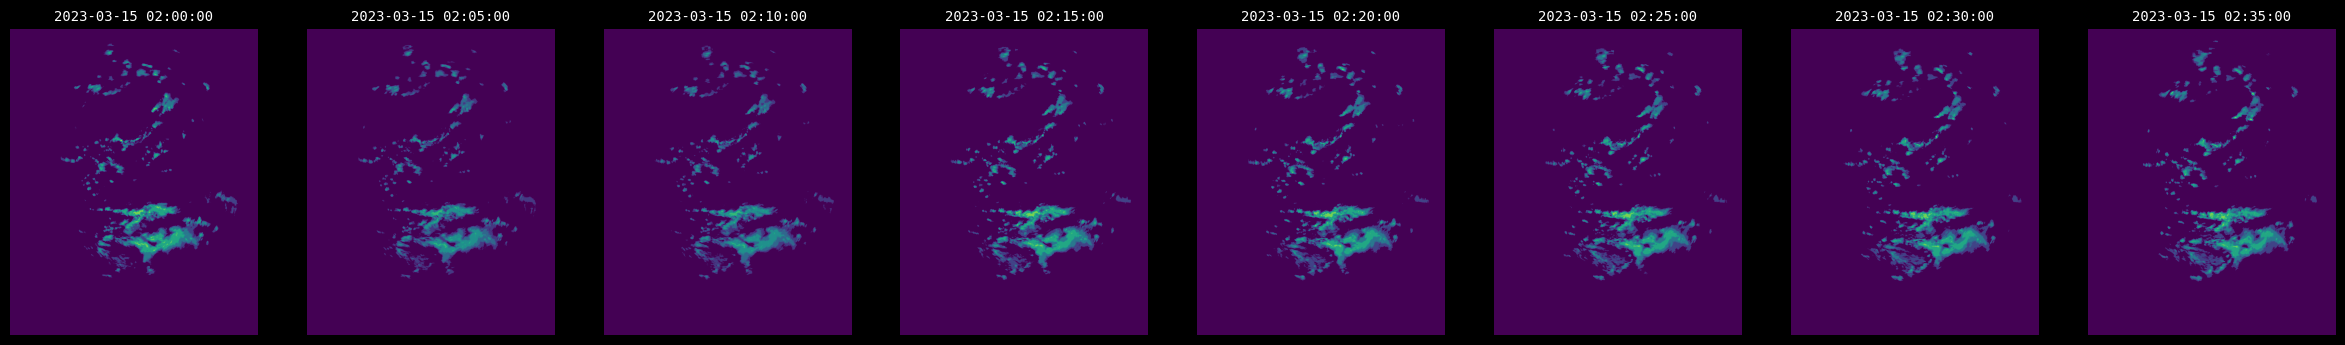

In [71]:
f, a = plt.subplots(1, 8, figsize=(30, 10))

for i, rest in enumerate(radarimg):
    a[i].imshow(rest)
    a[i].grid(True)
    a[i].axis('off')
    a[i].set_title(f"{timesRadar[i]}", color='white', font="monospace")

f.set_facecolor("black")

In [72]:
x = torch.from_numpy(np.array(x)).float().cuda()

In [73]:
test = (x, torch.zeros(1).cuda())

In [74]:
model.cuda()

Sat2Rad(
  (unet): UNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (groupnorm): GroupNorm(1, 12, eps=1e-05, affine=True)
            (conv): Conv3d(12, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (SingleConv2): SingleConv(
            (groupnorm): GroupNorm(1, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
        )
      )
      (1): Encoder(
        (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (groupnorm): GroupNorm(1, 64, eps=1e-05, affine=True)
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), b

In [75]:
model.eval()

Sat2Rad(
  (unet): UNet3D(
    (encoders): ModuleList(
      (0): Encoder(
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (groupnorm): GroupNorm(1, 12, eps=1e-05, affine=True)
            (conv): Conv3d(12, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
          (SingleConv2): SingleConv(
            (groupnorm): GroupNorm(1, 32, eps=1e-05, affine=True)
            (conv): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
            (ReLU): ReLU(inplace=True)
          )
        )
      )
      (1): Encoder(
        (pooling): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (basic_module): DoubleConv(
          (SingleConv1): SingleConv(
            (groupnorm): GroupNorm(1, 64, eps=1e-05, affine=True)
            (conv): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), b

In [41]:
with torch.no_grad():
    y_hat = model(test)

In [76]:
draw = model(test)

In [42]:
next(model.parameters()).is_cuda # returns a boolean

True

In [43]:
y_hat.shape

torch.Size([1, 8, 256, 256])

In [44]:
tttt = torch.softmax(y_hat, dim=1)

In [45]:
tttt.shape

torch.Size([1, 8, 256, 256])

In [46]:
torch.sum(tttt[0,:,0,0])

tensor(1., device='cuda:0')

In [47]:
pp = torch.argmax(tttt, axis=1)

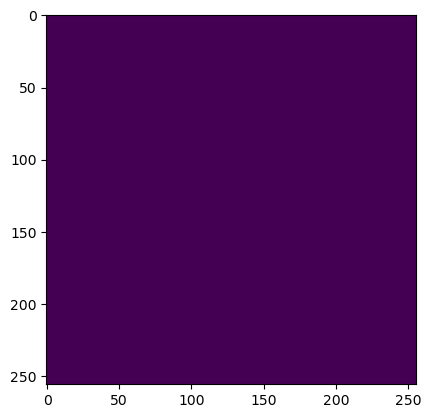

In [48]:
plt.imshow(pp.cpu().detach()[0])

In [49]:
import torchmetrics

In [50]:
cm = torchmetrics.ConfusionMatrix('multiclass', num_classes=8).to('cuda')

In [51]:
from torchvision.transforms.functional import resize, InterpolationMode

In [52]:
test = torch.from_numpy(radarimg[1])

In [53]:
test.shape

torch.Size([1660, 1340])

In [54]:
test = test.view(1, 1660, 1340)

In [55]:
y = resize(test, [256, 256], interpolation=InterpolationMode.NEAREST)

In [56]:
y = y.to('cuda')

In [57]:
y.device

device(type='cuda', index=0)

In [139]:
pp.device

device(type='cuda', index=0)

In [140]:
res = cm(pp, y)

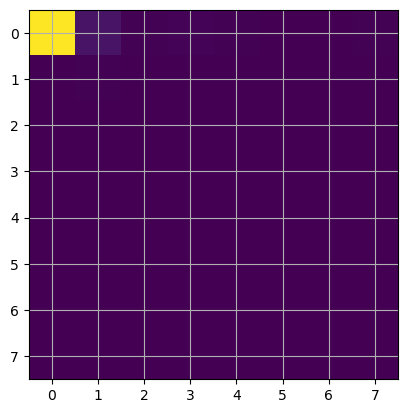

In [141]:
plt.imshow(res.cpu().detach().numpy())
plt.grid()

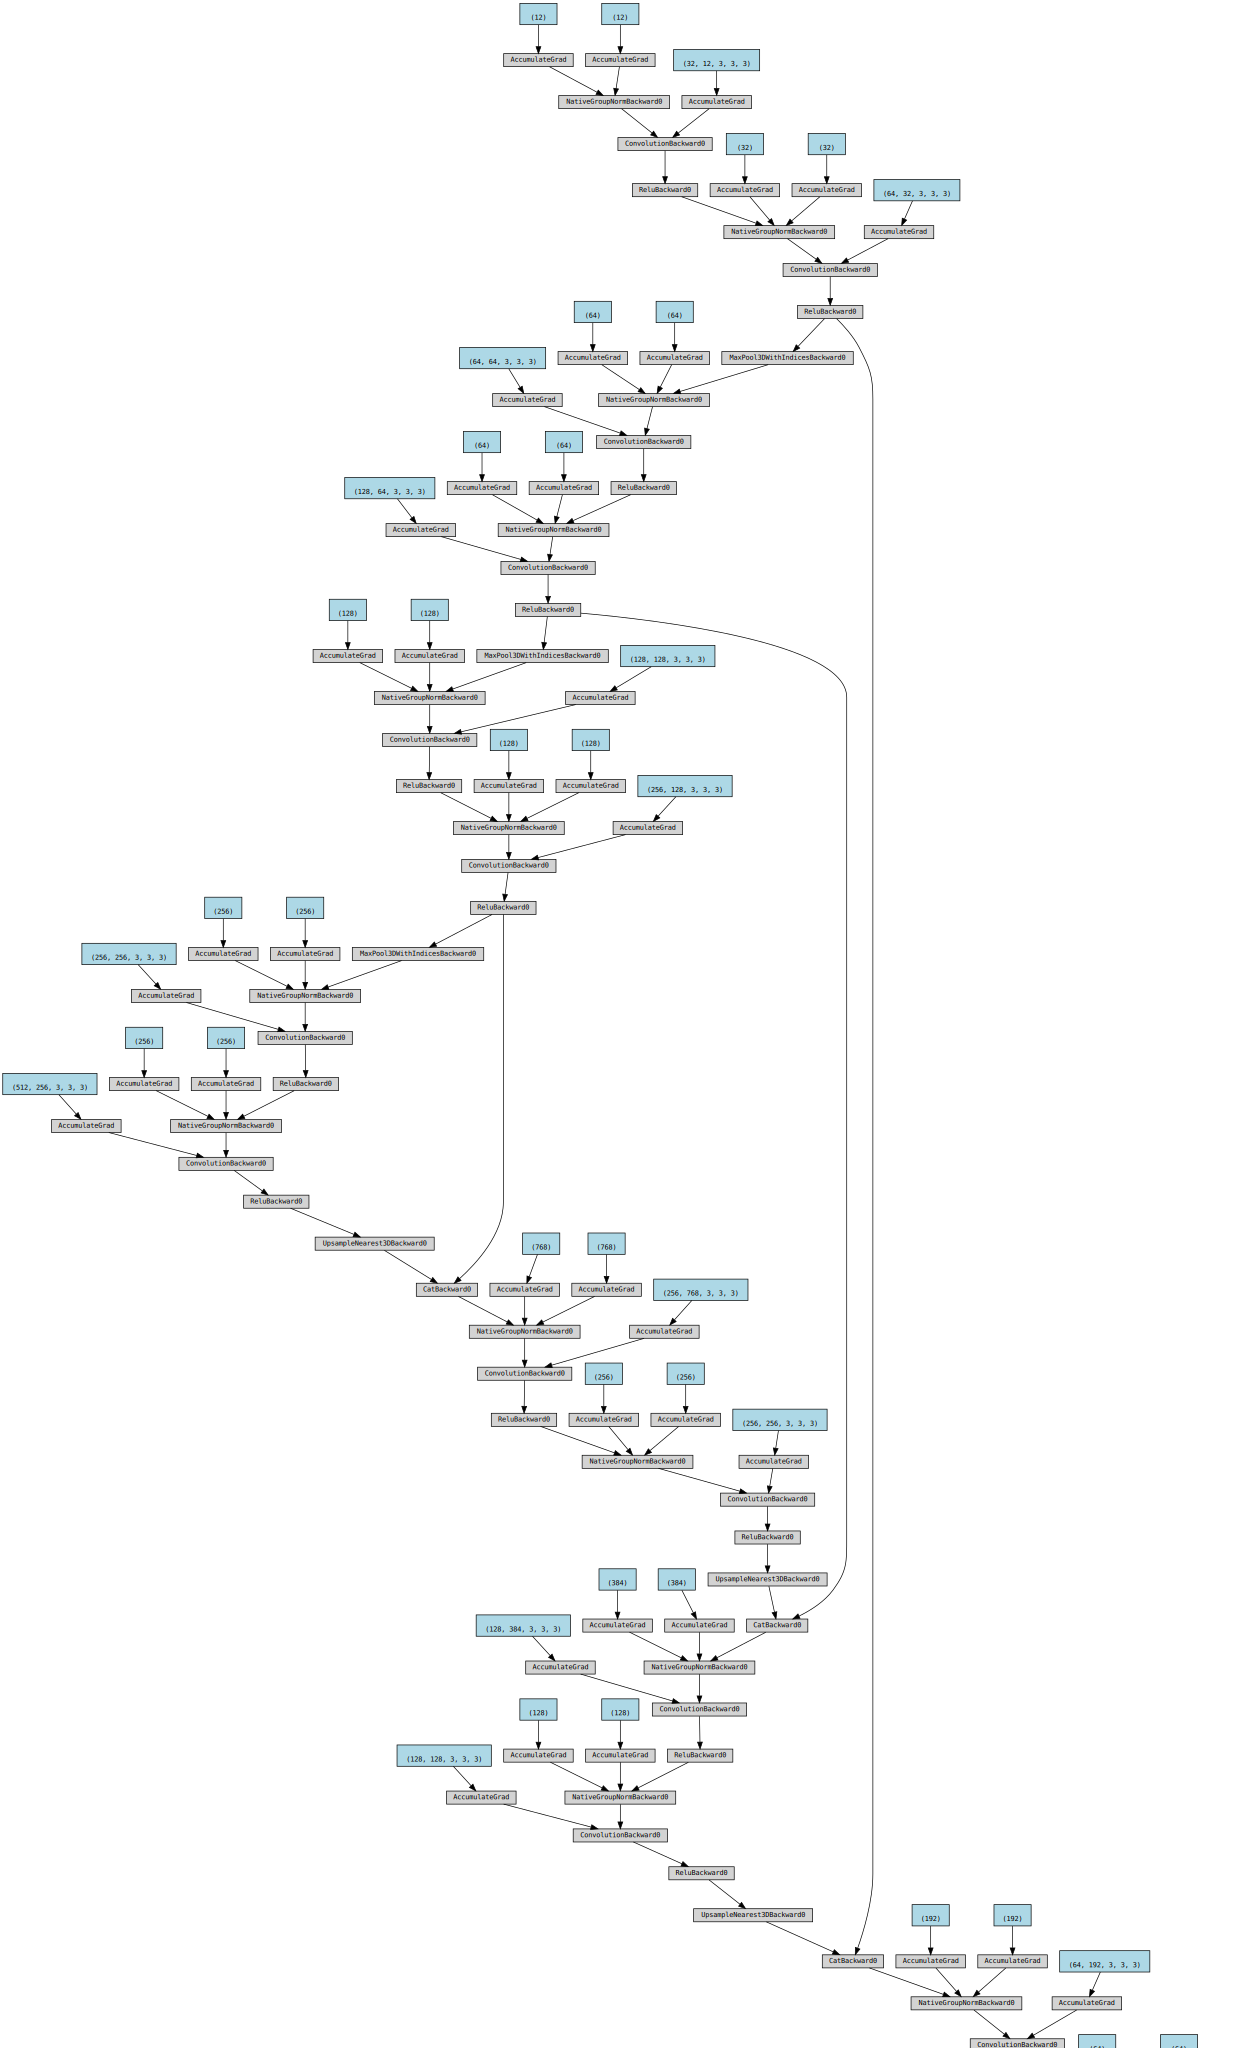

In [77]:
make_dot(draw)

In [164]:
from torch import nn

In [187]:
encode = nn.Sequential(
    nn.Conv2d(in_channels=12, out_channels=16, kernel_size=3),
    nn.ReLU(),
    nn.Conv2d(in_channels=16, out_channels=34, kernel_size=3, stride=2),
    nn.ReLU(),
    nn.Conv2d(in_channels=34, out_channels=64, kernel_size=3, stride=2),
)

In [188]:
image = torch.randn(1, 12, 256, 256)

In [189]:
out = encode(image)

In [190]:
out.shape

torch.Size([1, 64, 62, 62])